In [60]:
import os
import numpy as np
import pickle
import sys
import scipy.stats as stats
from tqdm import tqdm
import matplotlib.pyplot as plt
sys.path.append('../')
from utils import get_distance, haversineDistance
from placecell import PlaceNetwork, loadNetwork

In [31]:
def two_sample_t_test(data1, data2, alpha=0.05):
    t_statistic, p_value = stats.ttest_ind(data1, data2)
    degrees_of_freedom = len(data1) + len(data2) - 2
    critical_value = stats.t.ppf(1 - alpha / 2, degrees_of_freedom)
    reject_null = abs(t_statistic) > critical_value

    result = {
        't_statistic': t_statistic,
        'p_value': p_value,
        'degrees_of_freedom': degrees_of_freedom,
        'critical_value': critical_value,
        'reject_null': reject_null
    }

    return result

In [32]:
NAIVE_PATH = 'naive_pths.pkl'
RRT_PATH = 'rrt_pths.pkl'
SW_PATH = 'sw_pths.pkl'
ASTAR_PATH = 'astar_pths.pkl'

In [33]:
def loadFromFile(file):
    f = open(file, 'rb')
    data = pickle.load(f)
    return data

In [34]:
naive = loadFromFile(NAIVE_PATH)
rrt = loadFromFile(RRT_PATH)
sw = loadFromFile(SW_PATH)
astar = loadFromFile(ASTAR_PATH)

In [35]:
total = len(naive)
print(f"Total number of paths: {total}")

Total number of paths: 57086


In [36]:
sameasrrt = 0
sameasnaive = 0
sameasastar = 0
for n, r, s, a in zip(naive, rrt, sw, astar):
    if s == a:
        sameasastar += 1     
    if s == n:
        sameasnaive += 1
    if s == r:
        sameasrrt += 1

In [37]:
print(f"SWP and RRT same: {(sameasrrt / total) * 100:.2f}%")
print(f"SWP and naive same: {(sameasnaive / total) * 100:.2f}%")
print(f"SWP and astar same: {(sameasastar / total) * 100:.2f}%")

SWP and RRT same: 12.58%
SWP and naive same: 17.80%
SWP and astar same: 32.97%


In [38]:
network = PlaceNetwork()
data = loadNetwork("../fixed_wgts")
network.loadFromFile(data)

In [39]:
wgts = network.normalizeWeights([0, 1, 4, 5])

In [52]:
def calculateTotalCost(wgts, path):
    reversedpath = path[::-1]
    cost = 0
    for i in range(len(path) - 1):
        cost += wgts[(reversedpath[i], reversedpath[i+1])]
    return cost

def calculateTotalDistance(network, wgts, path):
    reversedpath = path[::-1]
    distance = 0
    for i in range(len(path) - 1):
        d1 = network.cells[path[i]].origin
        d2 = network.cells[path[i+1]].origin
        distance += haversineDistance(d1[0], d1[1], d2[0], d2[1])
    return distance

def distance(network, path):
    d1 = network.cells[path[0]].origin
    d2 = network.cells[path[-1]].origin
    return(haversineDistance(d1[0], d1[1], d2[0], d2[1]))

In [53]:
distances = [distance(network, i) for i in sw]

In [55]:
astarcosts = []
swpcosts = []
naivecosts = []

_swtotals = np.array([calculateTotalCost(wgts, i) for i in sw])
_distancessw = np.array([distance(network, i) for i in sw])

_astartotals = np.array([calculateTotalCost(wgts, i) for i in astar])
_distancesastar = np.array([distance(network, i) for i in astar])

_naivetotals = np.array([calculateTotalCost(wgts, i) for i in naive])
_distancesnaive = np.array([distance(network, i) for i in naive])

for d in range(0, 80):
    swpc = np.mean(_swtotals[np.array(_distancessw) > d])
    astarc = np.mean(_astartotals[np.array(_distancesastar) > d])
    naivec = np.mean(_naivetotals[np.array(_distancesnaive) > d])
    astarcosts.append(astarc)
    swpcosts.append(swpc)
    naivecosts.append(naivec)

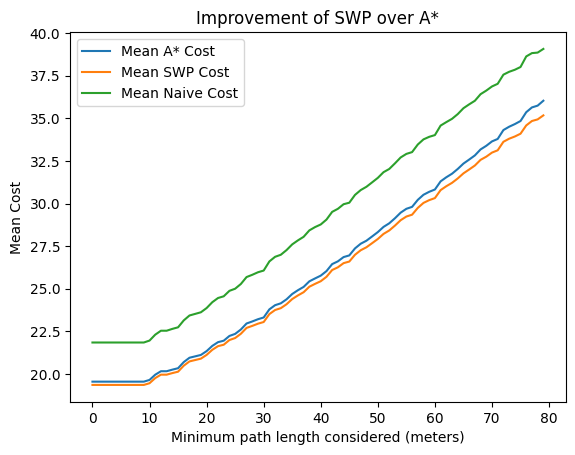

In [56]:
plt.figure()
plt.title("Improvement of SWP over A*")
plt.xlabel("Minimum path length considered (meters)")
plt.ylabel("Mean Cost")
plt.plot(astarcosts, label='Mean A* Cost')
plt.plot(swpcosts, label='Mean SWP Cost')
plt.plot(naivecosts, label='Mean Naive Cost')
plt.legend()
plt.show()

In [58]:
minimum_distance = 0

#COSTS
swp_costs = [calculateTotalCost(wgts, i) for i in sw if distance(network, i) > minimum_distance]
swp_avg = np.mean(swp_costs)

rrt_costs = [calculateTotalCost(wgts, i) for i in rrt if distance(network, i) > minimum_distance]
rrt_avg = np.mean(rrt_costs)

astar_costs = [calculateTotalCost(wgts, i) for i in astar if distance(network, i) > minimum_distance]
astar_avg = np.mean(astar_costs)

naive_costs = [calculateTotalCost(wgts, i) for i in naive if distance(network, i) > minimum_distance]
naive_avg = np.mean(naive_costs)

#DISTANCES
swp_dist = [calculateTotalDistance(network, wgts, i) for i in sw if distance(network, i) > minimum_distance]
swp_dist_avg = np.mean(swp_costs)

rrt_dist = [calculateTotalDistance(network, wgts, i) for i in rrt if distance(network, i) > minimum_distance]
rrt_avg = np.mean(rrt_costs)

astar_dist = [calculateTotalDistance(network, wgts, i) for i in astar if distance(network, i) > minimum_distance]
astar_dist_avg = np.mean(astar_costs)

naive_dist = [calculateTotalDistance(network, wgts, i) for i in naive if distance(network, i) > minimum_distance]
naive_dist_avg = np.mean(naive_costs)


In [47]:
rrt_result = two_sample_t_test(swp_costs, rrt_costs)
print(f"Mean swp cost: {np.mean(swp_costs)}")
print(f"Mean rrt cost: {np.mean(rrt_costs)}")
print(f"p-value: {rrt_result['p_value']}")

print("___________________________________________")

astar_result = two_sample_t_test(swp_costs, astar_costs)
print(f"Mean swp cost: {np.mean(swp_costs)}")
print(f"Mean astar cost: {np.mean(astar_costs)}")
print(f"p-value: {astar_result['p_value']}")

print("___________________________________________")

naive_result = two_sample_t_test(swp_costs, naive_costs)
print(f"Mean swp cost: {np.mean(swp_costs)}")
print(f"Mean naive cost: {np.mean(naive_costs)}")
print(f"p-value: {naive_result['p_value']}")

Mean swp cost: 19.356654400747683
Mean rrt cost: 22.066295101941122
p-value: 0.0
___________________________________________
Mean swp cost: 19.356654400747683
Mean astar cost: 19.548542238727688
p-value: 0.0002588291659747119
___________________________________________
Mean swp cost: 19.356654400747683
Mean naive cost: 21.845377554361562
p-value: 0.0


In [59]:
rrt_dist_result = two_sample_t_test(swp_dist, rrt_dist)
print(f"Mean swp cost: {np.mean(swp_dist)}")
print(f"Mean rrt cost: {np.mean(rrt_dist)}")
print(f"p-value: {rrt_dist_result['p_value']}")

print("___________________________________________")

astar_dist_result = two_sample_t_test(swp_dist, astar_dist)
print(f"Mean swp cost: {np.mean(swp_dist)}")
print(f"Mean astar cost: {np.mean(astar_dist)}")
print(f"p-value: {astar_dist_result['p_value']}")

print("___________________________________________")

naive_dist_result = two_sample_t_test(swp_dist, naive_dist)
print(f"Mean swp cost: {np.mean(swp_dist)}")
print(f"Mean naive cost: {np.mean(naive_dist)}")
print(f"p-value: {naive_dist_result['p_value']}")

Mean swp cost: 50.910470411071465
Mean rrt cost: 59.00588995741761
p-value: 0.0
___________________________________________
Mean swp cost: 50.910470411071465
Mean astar cost: 51.732074193787376
p-value: 6.499648863252795e-09
___________________________________________
Mean swp cost: 50.910470411071465
Mean naive cost: 47.731018958899746
p-value: 4.152574805279658e-121
